The first part to be done in this project is the conversion of provided R Code into Python format. The code was provided by my supervisor and it had to be analysed and rewritten using Python modules, pandas, and functions. The first section deals with the modules added to replicate the R packages

In [1]:
#library(R.matlab) is run as [from scipy.io import loadmat]
#library(hyperSpec) done through hyperspy and spectral modules
#library(ChemometricsWithR) is obtained through scipy modules and scikit-learn. 
#library(baseline) is part of scipy module
#library(ggplot2) is part of plotnine module
#library(pls) is part of sklearn module

import pandas as pd
import numpy as np
import peakutils
from scipy.io import loadmat
from scipy import signal, misc #Replaces signal library
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from BaselineRemoval import BaselineRemoval
from peakutils import baseline 
import math
from sklearn.preprocessing import normalize #PCA in sklearn
from sklearn import preprocessing

In [2]:
#Loading wavenumber data
wavenumber = loadmat("wavenumber.mat")
wavenumber = wavenumber['wavenumber']

#LNCaP
data = loadmat("LNCaP_0Gy.mat") #This loads the matlab file into the workspace as a 'list' object
LNCaP_0Gy = data['data'] #Extracting the LNCaP spectral data matrix from R Code

data = loadmat("LNCaP_IF.mat") #This loads the matlab file into the workspace as a 'list' object
LNCaP_IF = data['data'] 

After loading the main modules, we follow with the loading of the provided Mat format data. This requires converting the files into lists and setting named variables of the files to the array. The data can also be converted back into a matlab file once we are done with the arrays. Since the data is a large array, plotting the data visually is difficult without first attempting dimensionality reduction

In [3]:
#SG Filtering
numrow = LNCaP_0Gy.shape[0] # Shape functions as nrow and ncol but specificed to the array elements
numcol = LNCaP_0Gy.shape[1]
vec1= [] # creates empty list
vec1 = ["LNCaP 0GY"]*(numrow) #Simplified version of applying name to each row


filtLNCaP_0Gy = np.asmatrix(LNCaP_0Gy) # Should work in creating similar matrix

from scipy.signal import savgol_filter

for i,n in enumerate (LNCaP_0Gy[0]): #Removed {} and got sg filter from python, ordering is n,p,m versus p,n,m / for i, n in enumerate (LCAaP_0Gy[0]):
  filtLNCaP_0Gy == savgol_filter(LNCaP_0Gy, 13, 5, 0)

Savitzky–Golay Filtering is applied to the data abvoe, however difficulty is experienced trying to covert the idea of setting the vector to a null object, likely one of the functions is not correct for the type of vector data used. Once I reevaluated what this section was attemping in R code, I realised there was a similar method to add the data set name to the rows

The for loop was made to be work better using enumerate, which let the data be filtered without going outside the array dimensions.

In [5]:
#Baseline Correction
import numpy as np 
import matplotlib.pyplot as plt
import scipy.io as sio
import os


def rubber(spectra):
    
    result = np.zeros(spectra.shape)
    for i in range(spectra.shape[0]):
        spectrum = spectra[i, :]
        result[i,:] = rubberband(spectrum)
        
    spec_corr = spectra - result


    return spec_corr

def rubberband(spec):
    
    nf = len(spec)
    l = np.linspace(spec[0], spec[-1], nf)
    flat = spec -l
    min_value = np.min(flat)
    min_idx = np.argmin(flat) 
    if min_value.size != 0 and min_value <0 :

        line = np.concatenate((rubberband(spec[:min_idx+1]) , rubberband(spec[min_idx:])))
    else:
        line = l
  
    line=line[0:len(spec)]

    return line


LNCaP_0Gy = rubber(LNCaP_0Gy)
  

Several baseline methods were tested, however none have been able to work so far. There may be an issue based in trying to copy the R code to closely, creating an array that python Baseline functions / methods cannot process. Looking back on the array data to find an issue may be able to get the baseline correction functions to work, however this understanding of the array form will require research as to why the original methods were used. Eventually this problem was overcome as a function was designed by a colleague that performed the baseline correction similar to that used in the R Code program [4S Peak Filling – baseline estimation by iterative mean suppression, a paper of which can be found at [https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4487348/]]

In [6]:
#SG Filtering for LNCAP_IF
numrow1 = LNCaP_IF.shape[0]
numcol1 = LNCaP_IF.shape[1]
vec2= []
vec2 = ["LNCaP 2GY"]*(numrow1)

filtLNCaP_IF = np.asmatrix(LNCaP_IF)

for i in range(1,numrow1):
    
  filtLNCaP_IF[i,] == savgol_filter(LNCaP_IF[i,],13, 5, 0)


In [7]:
ID = np.concatenate((vec1, vec2), axis=None).astype(str) #ID = as.character(c(vec1,vec2)), axis must be set to None to create singe dimension vector, then it is set as string type

#NORMALIZE spectra (vector normalization)
LNCaP_0Gy = preprocessing.normalize(LNCaP_0Gy) # Using sklearn normalizing, does not create same results as sweep function
LNCaP_IF = preprocessing.normalize(LNCaP_IF)

dataall = np.concatenate([LNCaP_0Gy,LNCaP_IF])

Concatenating vec1 and vec2 into a string vector was succesful, and similarly done with LNCaP_0Gy and LNCap_IF for datall. The Spectra Normalization was running but when tested, the values did not correpond to the same point as on the R code, even when compensating and not running the baseline code. 

Trying to fix it led to issues with the array being out of bounds ("index 1626 is out of bounds for axis 0 with size 1626"). This code was instead replaced with sklearn normalize, however it doesnt normalize like the R code sweep function, so this may be adjusted in future.

The main issue was as with the baseline package, there was no equivalent form of the sweep function in Python. The code used was based on similar attempts, posted online, of replicating the function in Python. This was eventually solved with a custom built function that performed the task to a similar degree

original shape:    (2354, 1626)
transformed shape: (2354, 2)
Explained variation per principal component: [0.6575867  0.22957757]


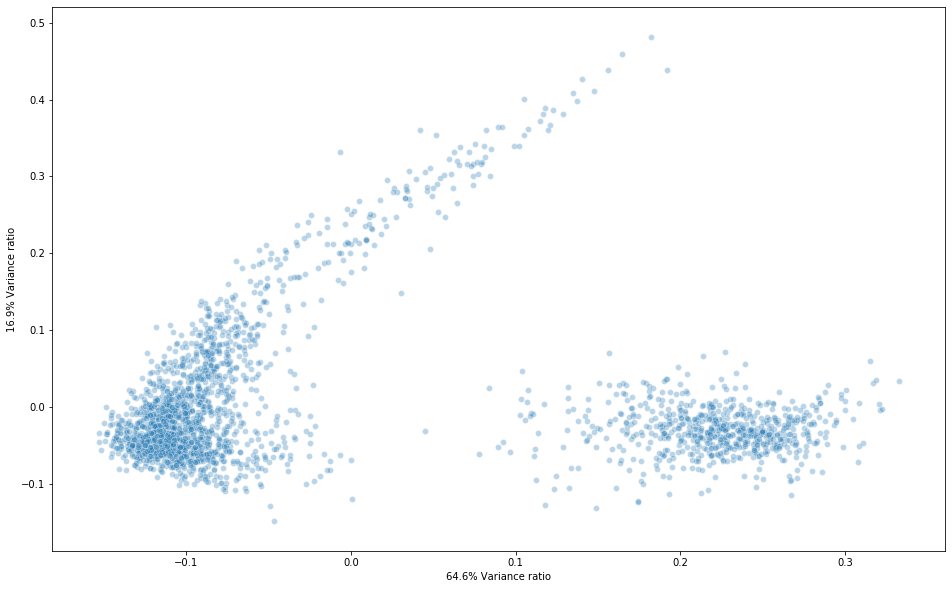

In [8]:
#PCA
from sklearn.decomposition import PCA
# Create a PCA instance: pca
pca = PCA(n_components = 2)
X_pca = pca.fit_transform(dataall)
print("original shape:   ", dataall.shape)
print("transformed shape:", X_pca.shape)
X_DF = pd.DataFrame(data = X_pca, columns = ['64.6% Variance ratio', '16.9% Variance ratio'])
print('Explained variation per principal component: {}'.format(pca.explained_variance_ratio_))

import seaborn as sns
plt.figure(figsize=(16,10))
sns.scatterplot(
    x="64.6% Variance ratio", y="16.9% Variance ratio",
    palette=sns.color_palette("hls", 10),
    data=X_DF,
    legend="full",
    alpha=0.3
)

#plt.savefig('Dataset 1 & 2.png')

PCA analysis was performed on the concated datasets, and two principal components was kept. With n components of four, around 90% of the variance could be kept. A seaborn sns plot was performed on the data as traditional scatter plots did not seem to display the data accurately over the pc range. The sns plot showed the data to a more accurate degree but I was unable to have the plot distinguish between the two data sets. 

In [9]:
#PNT1A

###################First two data sets
data = loadmat("PNT1A_0Gy.mat") #This loads the matlab file into the workspace as a 'list' object
PNT1A_0Gy = data['data']  #Extracting the PNT1A PNT1A.0Gytral data matrix

data = loadmat("PNT1A_OF.mat") #This loads the matlab file into the workspace as a 'list' object
PNT1A_OF = data['data'] 

#SG Filtering 
numrow = PNT1A_0Gy.shape[0]
numcol = PNT1A_0Gy.shape[1]

filtPNT1A_0Gy = np.asmatrix(PNT1A_0Gy)

for i, n in enumerate (PNT1A_0Gy[0]):
    
  filtPNT1A_0Gy == savgol_filter(PNT1A_0Gy,13, 5, 0)

#Baseline Correction / basline.fill peaks method 4s Peaks method
PNT1A_0Gy = rubber(PNT1A_0Gy)

#SG Filtering 
numrow1 = PNT1A_OF.shape[0]
numcol1 = PNT1A_OF.shape[1]

filtPNT1A_OF = np.asmatrix(PNT1A_OF)

for i, n in enumerate (PNT1A_OF[0]):
    
  filtPNT1A_OF == savgol_filter(PNT1A_OF,13, 5, 0)

#Baseline Correction
PNT1A_OF = rubber(PNT1A_OF)

#NORMALIZE spectra (vector normalization)
PNT1A_0Gy = preprocessing.normalize(PNT1A_0Gy)
PNT1A_OF = preprocessing.normalize(PNT1A_OF)

#######################Second two data sets
data = loadmat("PNT1A_0Gy_ICCM.mat") #This loads the matlab file into the workspace as a 'list' object
PNT1A_0Gy_ICCM = data['data']  #Extracting the spectral data matrix


data = loadmat("PNT1A_OF_ICCM.mat") #This loads the matlab file into the workspace as a 'list' object
PNT1A_OF_ICCM = data['data'] 


#SG Filtering
numrow = PNT1A_0Gy_ICCM.shape[0]
numcol = PNT1A_0Gy_ICCM.shape[1]

filtPNT1A_0Gy_ICCM = np.asmatrix(PNT1A_0Gy_ICCM)


for i, n in enumerate (PNT1A_0Gy_ICCM[0]):
    
  filtPNT1A_0Gy_ICCM == savgol_filter(PNT1A_0Gy_ICCM,13, 5, 0)

#Baseline Correction
PNT1A_0Gy_ICCM = rubber(PNT1A_0Gy_ICCM)  
  
#SG Filtering
numrow1 = PNT1A_OF_ICCM.shape[0]
numcol1 = PNT1A_OF_ICCM.shape[1]

filtPNT1A_OF_ICCM = np.asmatrix(PNT1A_OF_ICCM)

for i, n in enumerate (PNT1A_OF_ICCM[0]):
    
  filtPNT1A_OF_ICCM == savgol_filter(PNT1A_OF_ICCM,13, 5, 0)


#Baseline Correction 
PNT1A_OF_ICCM = rubber(PNT1A_OF_ICCM)  

#NORMALIZE spectra (vector normalization)
PNT1A_0Gy_ICCM = preprocessing.normalize(PNT1A_0Gy_ICCM)
PNT1A_OF_ICCM = preprocessing.normalize(PNT1A_OF_ICCM)


This section is similar to the previous sections, simply using new datasets. Normalization was followed as previous, and baseline was applied to all datasets. Issues with describing the data prior to dimensionality reduction was still present but likely did not have an easy solution

original shape:    (2253, 1626)
transformed shape: (2253, 2)
Explained variation per principal component: [0.59238793 0.23512115]


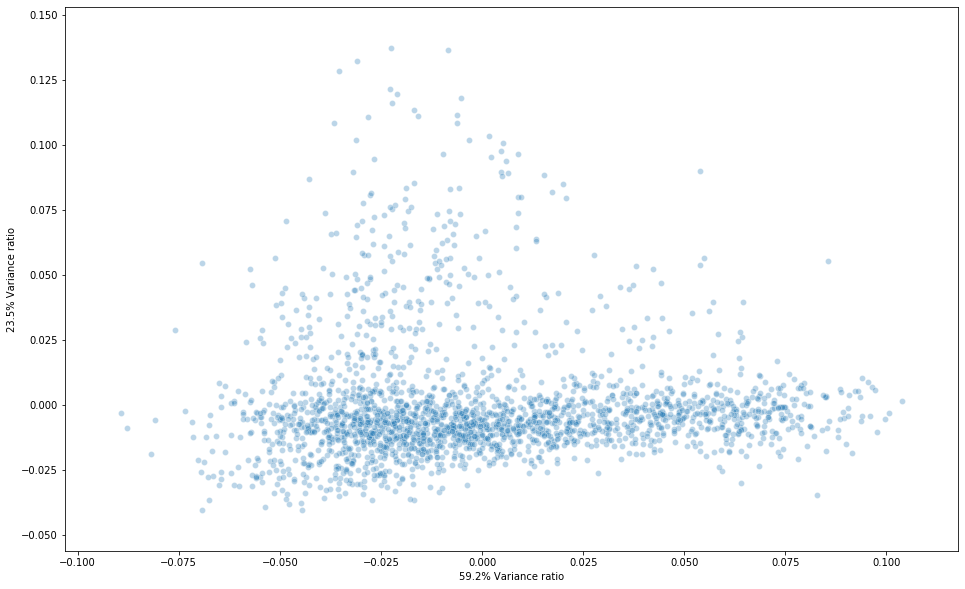

In [11]:
#FOUR WAY PCA PNT1A in each of 4 classes 
numrow = PNT1A_0Gy.shape[0]
vec1 = []
vec1 = ["PNT1A 0Gy"]*(numrow)

numrow2 = PNT1A_0Gy_ICCM.shape[0]
vec2 = []
vec2 = ["PNT1A 0Gy + ICCM"]*(numrow2)

numrow3 = PNT1A_OF.shape[0]
vec3 = []
vec3 = ["PNT1A OF"]*(numrow3)

numrow4 = PNT1A_OF_ICCM.shape[0]
vec4 = []
vec4 = ["PNT1A OF + ICCM"]*(numrow4)


dataall = np.concatenate([PNT1A_0Gy,PNT1A_0Gy_ICCM,PNT1A_OF,PNT1A_OF_ICCM])
ID = np.concatenate((vec1, vec2, vec3, vec4), axis=None).astype(str)

#PCA 
pca = PCA(n_components = 2)
Y_pca = pca.fit_transform(dataall)
print("original shape:   ", dataall.shape)
print("transformed shape:", Y_pca.shape)
Y_DF = pd.DataFrame(data = Y_pca, columns = ['59.2% Variance ratio', '23.5% Variance ratio'])
print('Explained variation per principal component: {}'.format(pca.explained_variance_ratio_))

plt.figure(figsize=(16,10))
sns.scatterplot(
    x="59.2% Variance ratio", y="23.5% Variance ratio",
    palette=sns.color_palette("hls", 10),
    data=Y_DF,
    legend="full",
    alpha=0.3
)

A similar issue was encountered with the sns plot as the different data in the data set wasnt distinguisable